# Map visualizations of Airbnb Data

**References:**  
https://www.kaggle.com/geowiz34/maps-of-nyc-airbnbs-with-python  
http://cs229.stanford.edu/proj2018/report/96.pdf  
https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391

**NYC borough map:**   
https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

### Import necessary packages 

In [49]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import seaborn as sns
import geopandas as gpd
from shapely import wkt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Read in data
- Get latitude, longitude, and price from listings data (currently using listings_reduced.csv)
- Get NYC neighbord map (pulled from URL in top section

In [50]:
#Get cleaned listings data 

df_cleaned = pd.read_csv('./data_input/listings_cleaned_new.csv')
df_cleaned.dropna(inplace=True)
df_cleaned = df_cleaned[['id','latitude', 'longitude', 'price']]
#df_cleaned.head()
df_cleaned.shape

(30641, 4)

In [51]:
#Get NYC neighborhood data/map

df_nbhoods = pd.read_csv('./data_input/nynta.csv')
df_nbhoods.head()

,BoroCode,CountyFIPS,the_geom,BoroName,NTACode,NTAName,Shape_Leng,Shape_Area
0,3,47,MULTIPOLYGON (((-73.97604935657381 40.63127590...,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07
1,4,81,MULTIPOLYGON (((-73.80379022888246 40.77561011...,Queens,QN51,Murray Hill,33266.904872,5.248828e+07
2,4,81,MULTIPOLYGON (((-73.8610972440186 40.763664477...,Queens,QN27,East Elmhurst,19816.712132,1.972685e+07
3,3,47,MULTIPOLYGON (((-73.94826499590911 40.63860718...,Brooklyn,BK95,Erasmus,18756.701865,1.452260e+07
4,4,81,MULTIPOLYGON (((-73.75725671509139 40.71813860...,Queens,QN07,Hollis,20976.335600,2.288777e+07


### Convert neighborhood data into Geopandas GeoDataFrame

In [52]:
#Clean and process neighboorhood data

df_nbhoods.rename(columns={'NTAName':'neighborhood'}, inplace=True)
df_nbhoods['geom'] = df_nbhoods['the_geom'].apply(wkt.loads)

<AxesSubplot:>

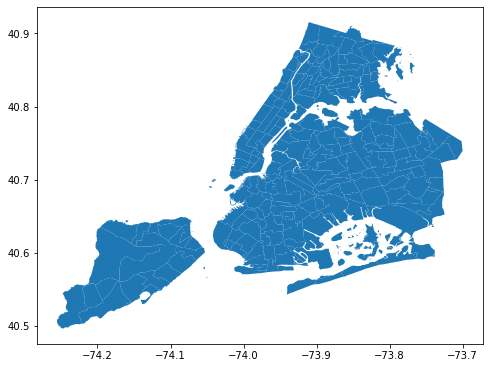

In [53]:
#Convert into Geopandas GeoDataFrame and plot

df_nbhoods = gpd.GeoDataFrame(df_nbhoods, geometry='geom')
fig,ax = plt.subplots(1,1, figsize=(8,8))
df_nbhoods.plot(ax=ax)

### Create points for each listing
- Designate coordinate system
- Zip x and y coordinates into single Point feature
- Create Geopandas dataframe with listings data


In [54]:
crs = {'init':'espc:4326'}
geometry = [Point(xy) for xy in zip(df_cleaned['longitude'], df_cleaned['latitude'])]
df_geo = gpd.GeoDataFrame(df_cleaned, crs = crs, geometry = geometry)

### Assign pricing tiers

In [13]:
metrics = df_cleaned['price'].describe()
metrics

count    30641.000000
mean       134.178826
std        157.590246
min          0.000000
25%         62.000000
50%         99.000000
75%        156.000000
max       5000.000000
Name: price, dtype: float64

In [14]:
tier1 = metrics.loc['min']
tier2 = metrics.loc['25%']
tier3 = metrics.loc['50%']
tier4 = metrics.loc['75%']

In [21]:
def classify_price_tier(price, tier1, tier2, tier3, tier4):
    if price >= tier1 and price < tier2: 
        return 'tier1'
    elif price >= tier2 and price < tier3:
        return 'tier2'
    elif price >= tier3 and price < tier4:
        return 'tier3'
    else:
        return 'tier4'

In [22]:
df_cleaned['price_tier'] = df_cleaned['price'].apply(lambda x: classify_price_tier(x, tier1, tier2, tier3, tier4))
df_cleaned.head()

,latitude,longitude,price,geometry,price_tier
1,40.68514,-73.95976,76.0,POINT (-73.95976 40.68514),tier2
3,40.66120,-73.99423,175.0,POINT (-73.99423 40.66120),tier4
4,40.76489,-73.98493,79.0,POINT (-73.98493 40.76489),tier2
5,40.80178,-73.96723,75.0,POINT (-73.96723 40.80178),tier2
6,40.71344,-73.99037,140.0,POINT (-73.99037 40.71344),tier3


### Create map with Airbnb price data

In [58]:
df_geo.head()

,id,latitude,longitude,price,geometry
1,3831,40.68514,-73.95976,76.0,POINT (-73.95976 40.68514)
3,5136,40.66120,-73.99423,175.0,POINT (-73.99423 40.66120)
4,5178,40.76489,-73.98493,79.0,POINT (-73.98493 40.76489)
5,5203,40.80178,-73.96723,75.0,POINT (-73.96723 40.80178)
6,5238,40.71344,-73.99037,140.0,POINT (-73.99037 40.71344)


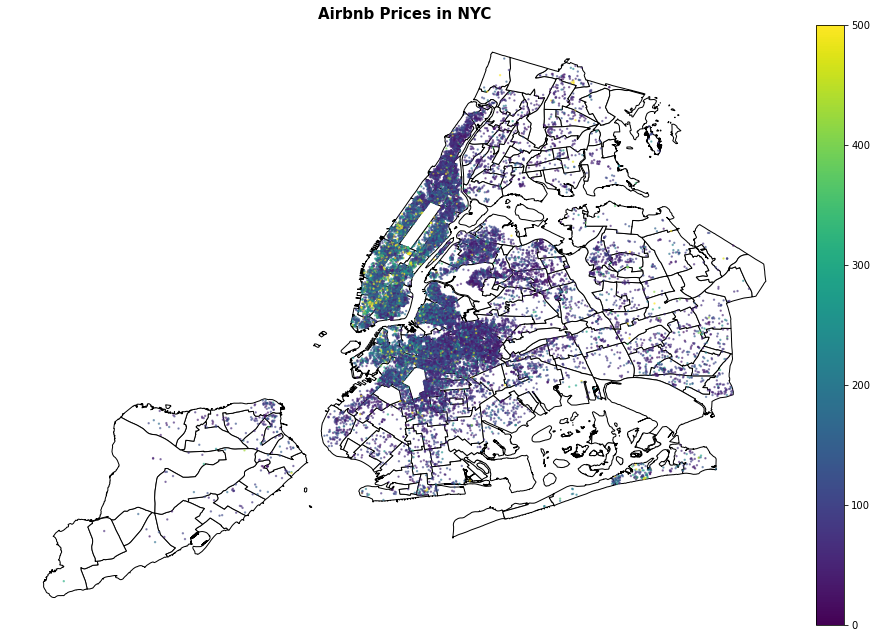

In [59]:
#Create figure and axes, assign to subplot

fig, ax = plt.subplots(figsize=(15,15))

ax.set_facecolor('white')
base = df_nbhoods.plot(color='white', edgecolor='black', ax=ax)

vmin = 0
vmax = 500
df_geo.plot(column='price',ax=base, alpha=0.5, legend=False, markersize=2,vmax=500)
plt.title('Airbnb Prices in NYC', fontsize=15, fontweight='bold')
plt.axis('off')


#Create colorbar legend and format
 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='3.5%', pad=0.2)
plt.axis('on')
#cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = plt.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=10) 

#plt.tight_layout()


plt.savefig('./visualizations/airbnb_prices.png')

plt.show()

### Create map with sentiment data

In [30]:
df_sent = pd.read_csv('./reviews_sentiment/reviews_sentiment_english.csv')

In [43]:
df_avg_sent = df_sent.groupby('listing_id',as_index = False, group_keys = False).agg({'sentiment':'mean'})

In [45]:
df_geo_join = pd.merge(df_geo, df_avg_sent, left_on = 'id', right_on ='listing_id', how = 'inner')

In [57]:
df_geo_join

,id,latitude,longitude,price,geometry,listing_id,sentiment
0,3831,40.68514,-73.95976,76.0,POINT (-73.95976 40.68514),3831,0.804008
1,5136,40.66120,-73.99423,175.0,POINT (-73.99423 40.66120),5136,0.996500
2,5178,40.76489,-73.98493,79.0,POINT (-73.98493 40.76489),5178,0.765014
3,5203,40.80178,-73.96723,75.0,POINT (-73.96723 40.80178),5203,0.939032
4,5238,40.71344,-73.99037,140.0,POINT (-73.99037 40.71344),5238,0.917368
...,...,...,...,...,...,...,...
30242,45223333,40.62433,-74.02865,54.0,POINT (-74.02865 40.62433),45223333,0.971500
30243,45224756,40.78850,-73.94758,49.0,POINT (-73.94758 40.78850),45224756,0.955800
30244,45240828,40.76786,-73.95461,95.0,POINT (-73.95461 40.76786),45240828,0.935900
30245,45242204,40.65521,-73.97999,45.0,POINT (-73.97999 40.65521),45242204,0.624900


(-74.28337047814921,
 -73.67222994821336,
 40.475144526098404,
 40.936503646095986)

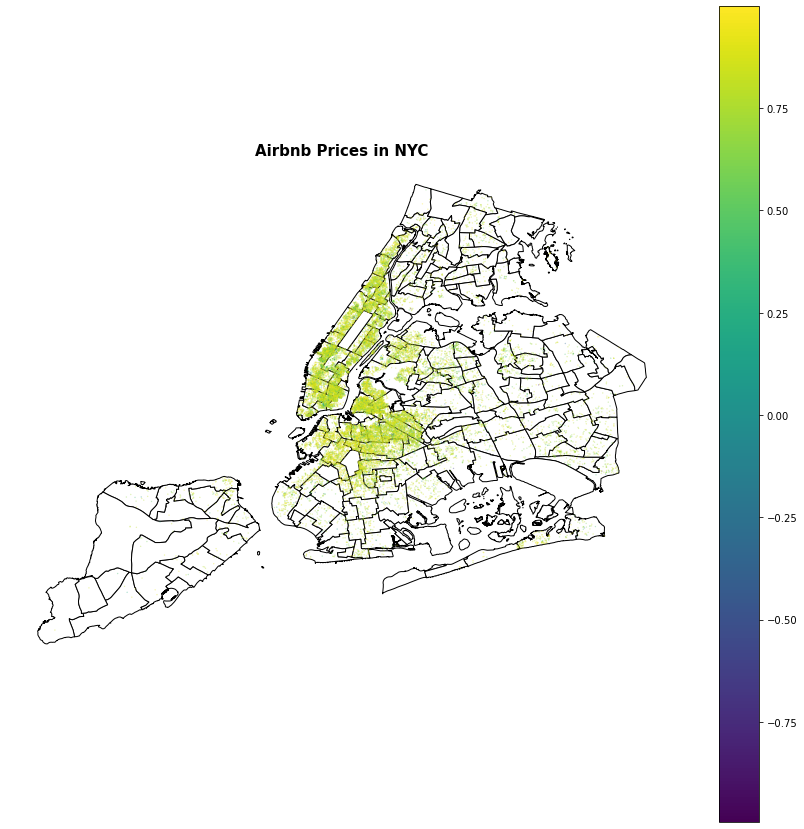

In [64]:
fig, ax = plt.subplots(figsize=(15,15))

ax.set_facecolor('white')
base = df_nbhoods.plot(color='white', edgecolor='black', ax=ax)

df_geo_join.plot(column='sentiment',ax=base, alpha=0.5, markersize=.1, legend = True)
plt.title('Airbnb Prices in NYC', fontsize=15, fontweight='bold')
plt.axis('off')

### Create map with price tiers

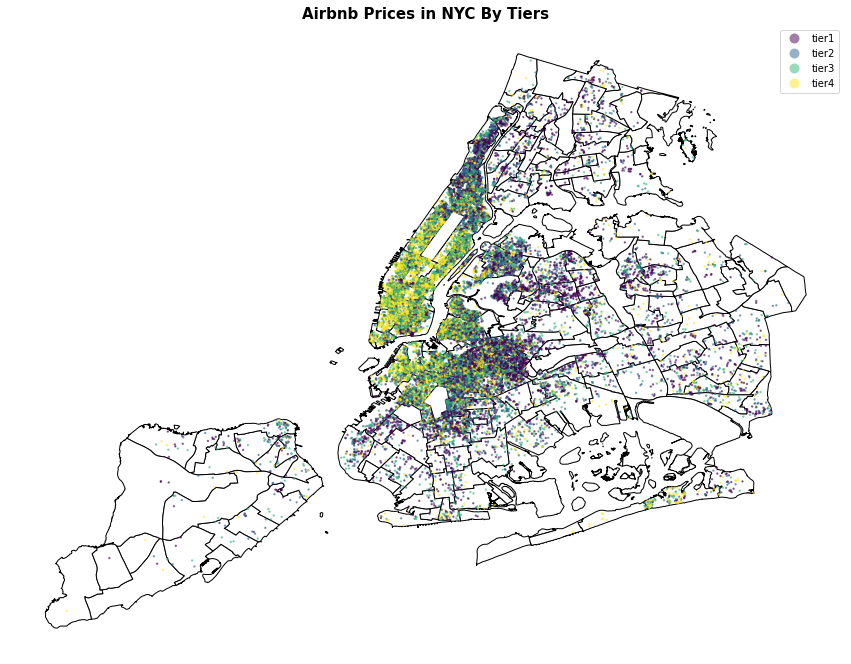

In [26]:
#Create figure and axes, assign to subplot

fig, ax = plt.subplots(figsize=(15,15))

ax.set_facecolor('white')
base = df_nbhoods.plot(color='white', edgecolor='black', ax=ax)

df_geo.plot(column='price_tier',ax=base, alpha=0.5, legend=True, markersize=2, categorical=True, cmap='viridis')
plt.title('Airbnb Prices in NYC By Tiers', fontsize=15, fontweight='bold')
plt.axis('off')


#Create colorbar legend and format

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size='3.5%', pad=0.2)
# plt.axis('on')
# #cax = fig.add_axes([1, 0.1, 0.03, 0.8])
# sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# cbr = plt.colorbar(sm, cax=cax)
# cbr.ax.tick_params(labelsize=10) 

#plt.tight_layout()


plt.savefig('./visualizations/airbnb_prices_tiers.png')

plt.show()